In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from pyhocon import ConfigFactory as hocon
import random
import numpy as np
from tuna import *
from collections import defaultdict
from glob import glob
from sgd_lsl import plot_matrix
from matplotlib import pyplot as plot

In [18]:
with open('test_baseline/params.json', 'r') as infile:
    weights = defaultdict(float, json.load(infile))

In [19]:
words, attrs = zip(*[f.split('|') for f in weights.keys()])
words = sorted(set(words))
attrs = sorted(set(attrs))

In [20]:
print len(words), len(attrs)

158 24


In [21]:
def l2_norm_sq(pair):
    s, vec = pair
    return np.sum(vec ** 2)

word_vecs = sorted([(w, np.array([weights['%s|%s' % (w, a)] for a in attrs]))
                    for w in words], key=l2_norm_sq, reverse=True)
words_sorted, word_vecs = zip(*word_vecs)
attr_vecs = sorted([(a, np.array([weights['%s|%s' % (w, a)] for w in words_sorted]))
                    for a in attrs], key=l2_norm_sq, reverse=True)
attrs_sorted, attr_vecs = zip(*attr_vecs)

attrs_mat = np.array(attr_vecs)
words_mat = np.array(word_vecs)

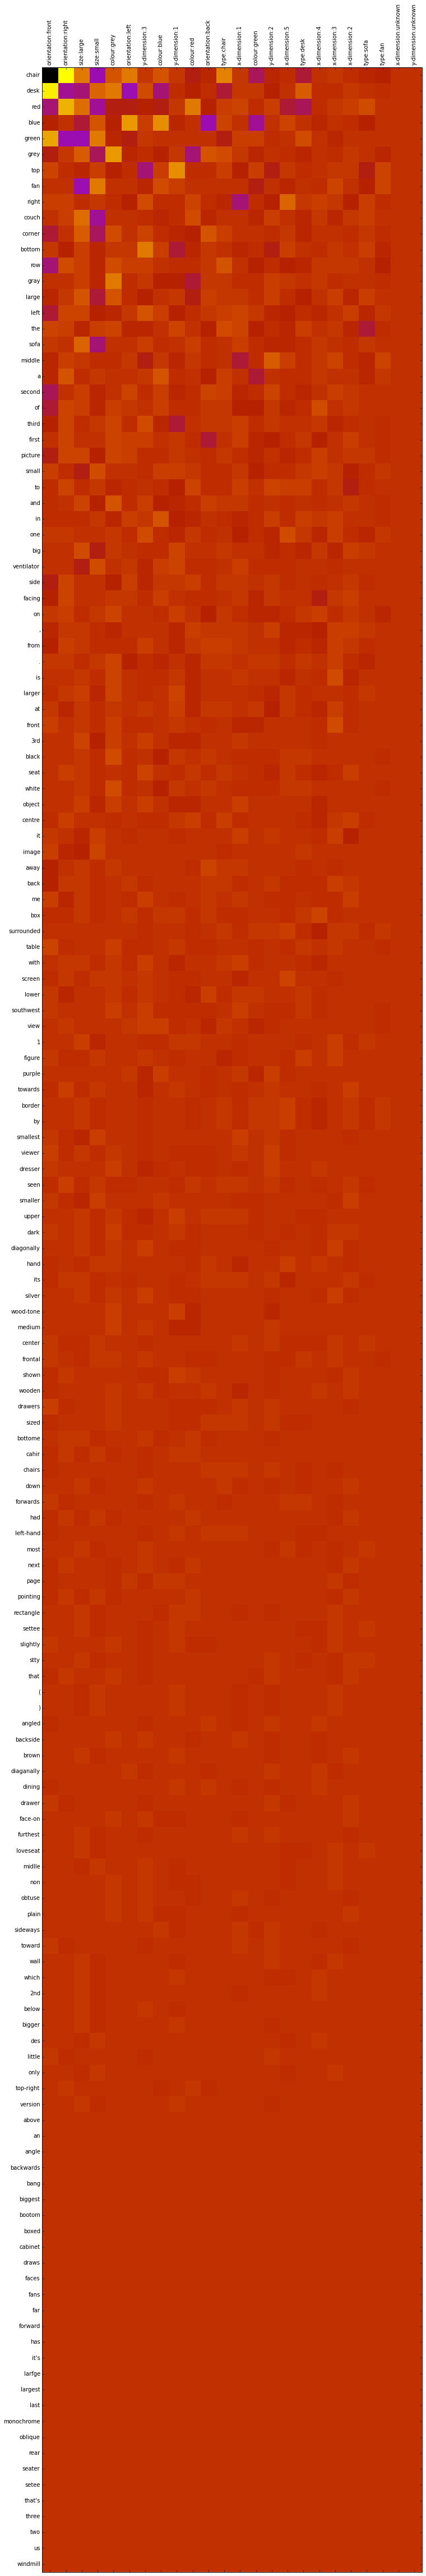

In [22]:
plot.figure(figsize=(15, 80))
plot_matrix(attrs_mat.T, xlabels=attrs_sorted, ylabels=words_sorted)

In [18]:
with open('runs/39/predictions.0.jsons', 'r') as infile:
    preds = [json.loads(line) for line in infile]

In [24]:
import metrics
md = np.array([metrics.multiset_dice(y, prediction)
               for (i, x, y, prediction) in preds])
print '%f +/- %f' % (md.mean(), md.std())

0.702331 +/- 0.248448


In [189]:
def load_json(filename):
    false = False
    true = True
    null = None
    with open(filename, 'r') as infile:
        return defaultdict(lambda: None, eval(infile.read()))

def extract_accuracy(stdout_file):
    accuracy = None
    acc_std = None
    error = float('nan')
    try:
        with open(stdout_file, 'r') as infile:
            for line in infile:
                if line.startswith('Error:'):
                    error = float(line.split()[1])
                
                if line.startswith('accuracy mean:'):
                    accuracy = float(line.split()[2])
                elif line.startswith('accuracy std:'):
                    acc_std = float(line.split()[2])
                elif '--' in line:
                    tokens = line.split(':')[-1].split()
                    acc_str = tokens[0]
                    try:
                        ci_lower, ci_upper = tokens[1][1:-1].split('--')
                    except IndexError:
                        print line
                        ci_lower = ci_upper = 0.0
                    return float(acc_str), (float(ci_lower), float(ci_upper)), error
                elif line.startswith('Mean accuracy:'):
                    tokens = line.split()
                    acc_str = tokens[2]
                    try:
                        std_str = tokens[4]
                        if std_str.endswith(')'): std_str = std_str[:-1]
                    except IndexError:
                        print line
                        std_str = '0.0'
                    return float(acc_str), float(std_str), error
    except IOError, e:
        #print '%s: %s' % (stdout_file, e)
        return None, None, None
    #if accuracy is None:
        #print '%s: accuracy mean not found' % stdout_file
    return accuracy, acc_std, error

def summary(config):
    cpbaseline = ('trials' in config)
    mat_size = ('(%s%s)' % (config['mat_size'],
                            'noamb' if config['ambiguities'] is False else '')
                if config['artificial'] or not config['data_dir'] else '')
    
    dataset = '%s%s' % (config['data_dir'],
                        '(generation)' if config['generation'] else '')
    
    return dataset, '%s%s%s%s%s%s%s%s%s eta=%s l2=%s feats=%s' % (
        dataset,
        ' literal' if config['literal'] else '',
        ' cpbaseline' if cpbaseline else '',
        ' sampled' if config['samples_x'] else '',
        ' relevant' if config['only_relevant_alts'] else '',
        ' null' if config['null_message'] else '',
        ' artificial' if config['artificial'] else '',
        ' loc=%s' % config['filter_loc'] if config['filter_loc'] is not None else '',
        mat_size,
        config['sgd_eta'],
        config['l2_coeff'],
        str(config['features']) if config['features'] else 'default',
    )

In [202]:
import math

best = defaultdict(lambda: (None, {}, 0.0, 0.0))

def accept(config):
    return True

error_corr = defaultdict(list)

for dirname in sorted(glob('runs/*')):
    statsfile = os.path.join(dirname, '_qry.json')
    configfile = os.path.join(dirname, 'config.json')
    try:
        stats = load_json(statsfile)
    except Exception, e:
        #print '%s: %s' % (statsfile, e)
        continue
    try:
        config = load_json(configfile)
    except Exception, e:
        #print '%s: %s' % (configfile, e)
        config = defaultdict(lambda: None)

    data_dir = config['data_dir']
    accuracy = None
    error = float(stats['Error']) if 'Error' in stats else float('nan')
    if 'accuracy mean' in stats.keys():
        accuracy = float(stats['accuracy mean'])
        acc_std = float(stats['accuracy std'])
    else:
        for key, value in stats.iteritems():
            if key.startswith('Mean accuracy'):
                accuracy = float(key.split()[2])
                acc_std = float(value[:-1])
                break
    
    if accuracy is None:
        accuracy, acc_std, error = extract_accuracy(os.path.join(dirname, 'stdout.log'))

    if accuracy and accept(config):
        settings = ''.join((str(config['data_dir']),
                            '(generation)' if config['generation'] else ''))
        _, _, best_acc, _ = best[settings]
        if hasattr(acc_std, '__len__'):
            metrics = '%5.3f (%5.3f--%5.3f) %8.3f' % ((accuracy,) + acc_std + (error,))
        else:
            metrics = '%5.3f ~%5.3f         %8.3f' % (accuracy, acc_std, error)
        print metrics, summary(config)[1], dirname
        if not math.isnan(error):
            error_corr[summary(config)[0]].append((accuracy, error))
        if accuracy > best_acc:
            best[settings] = (dirname, config, accuracy, acc_std)


print
for settings, (run, config, accuracy, acc_std) in best.iteritems():
    if run is not None:
        print '%s: %s ~%s (%s %s)' % (settings, accuracy, acc_std, run, summary(config)[1])

0.890 ~0.000           18.035 singular/furniture eta=0.1 l2=None feats=default runs/11
0.880 ~0.000           87.944 singular/furniture eta=0.1 l2=0.05 feats=default runs/12
0.890 ~0.000           31.509 singular/furniture eta=0.1 l2=0.01 feats=default runs/13
0.610 ~0.070           29.842 singular/furniture literal eta=0.1 l2=0.01 feats=default runs/141
0.240 ~0.030          774.511 singular/furniture(generation) eta=0.1 l2=0.01 feats=default runs/142
0.110 ~0.020          -15.448 plural/furniture(generation) eta=0.1 l2=0.01 feats=default runs/144
0.820 ~0.050          288.864 singular/furniture literal eta=0.1 l2=0.01 feats=default runs/146
0.410 ~0.070          166.939 singular/people literal eta=0.1 l2=0.01 feats=default runs/147
0.520 ~0.030          490.835 plural/furniture literal eta=0.1 l2=0.01 feats=default runs/148
0.290 ~0.050          211.388 plural/people literal eta=0.1 l2=0.01 feats=default runs/149
0.240 ~0.030          553.425 singular/furniture(generation) eta=0.01 l

plural/furniture(generation)


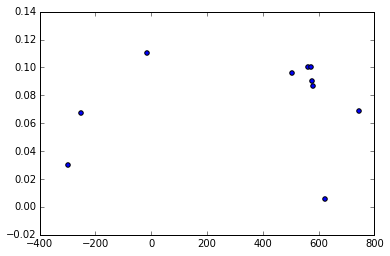

plural/people


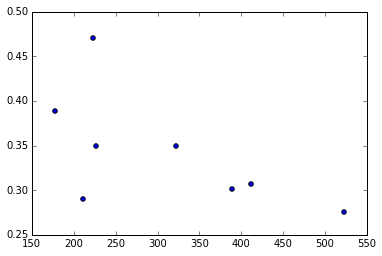

plural/people(generation)


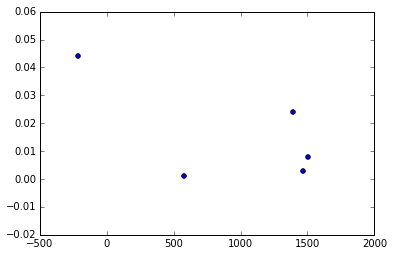

singular/people


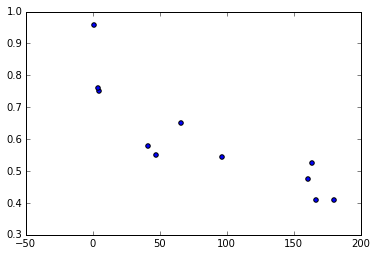

singular/people(generation)


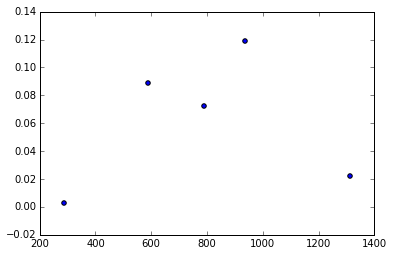

singular/furniture


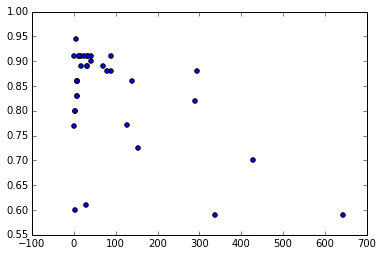

singular/furniture(generation)


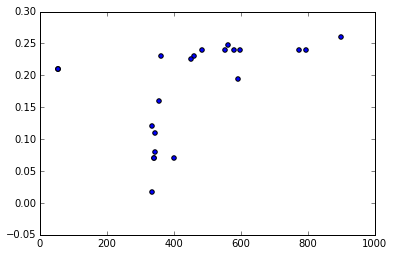

plural/furniture


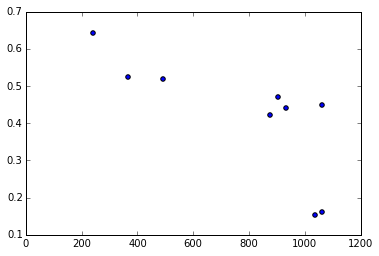

In [182]:
for dataset, pairs in error_corr.iteritems():
    print dataset
    y, x = zip(*pairs)
    plot.scatter(x, y)
    plot.show()

In [103]:
c = hocon.parse_file('runs/42/_qry.json')

In [38]:
c.keys()

['begin_time',
 'end_time',
 'elapsed_time',
 'host',
 'working_dir',
 'run_dir',
 'git_rev',
 'Trials',
 'Train percentage',
 '"Mean iterations to convergence:  99.00 (+/"',
 '"Mean accuracy: 0.04 (+/"',
 'Learning rate']

In [28]:
from training_instances import get_singular_instances

insts = get_singular_instances(glob('../TUNA/corpus/singular/furniture/*.xml'))
print len(insts)

420


In [29]:
insts[0]

(['grey', 'frontal', 'table'],
 ['colour:grey',
  'orientation:front',
  'type:desk',
  'size:large',
  'x-dimension:4',
  'y-dimension:1'],
 [['colour:grey',
   'orientation:front',
   'type:desk',
   'size:large',
   'x-dimension:4',
   'y-dimension:1'],
  ['colour:blue',
   'orientation:front',
   'type:desk',
   'size:large',
   'x-dimension:4',
   'y-dimension:3'],
  ['colour:red',
   'orientation:back',
   'type:desk',
   'size:large',
   'x-dimension:3',
   'y-dimension:3'],
  ['colour:green',
   'orientation:left',
   'type:desk',
   'size:small',
   'x-dimension:2',
   'y-dimension:2'],
  ['colour:blue',
   'orientation:front',
   'type:fan',
   'size:large',
   'x-dimension:5',
   'y-dimension:1'],
  ['colour:red',
   'orientation:back',
   'type:fan',
   'size:large',
   'x-dimension:4',
   'y-dimension:2'],
  ['colour:green',
   'orientation:left',
   'type:fan',
   'size:small',
   'x-dimension:5',
   'y-dimension:3']])

In [32]:
len(set((tuple(x), tuple(y)) for x, y, d in insts))

410

In [129]:
from training_instances import get_generation_instances

insts = get_generation_instances(glob('../TUNA/corpus/plural/people/*.xml'))
print len(insts)

720


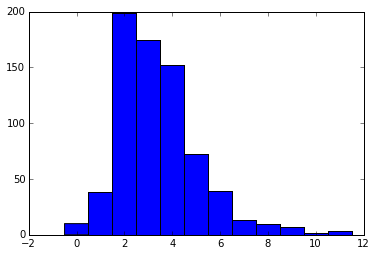

In [134]:
dist, _, _ = plot.hist([len(i[2]) for i in insts], bins=np.arange(-0.5, 12.5, 1.0))

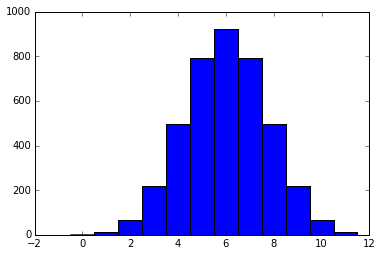

In [138]:
dist_alts, _, _ = plot.hist([len(a) for a in insts[0][-1]], bins=np.arange(-0.5, 12.5, 1.0))

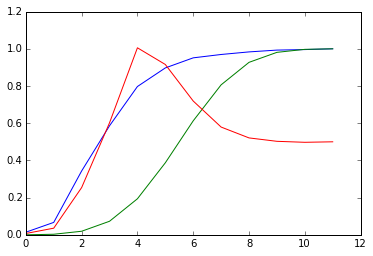

In [146]:
true_cum = np.cumsum(dist) / sum(dist)
alts_cum = np.cumsum(dist_alts) / sum(dist_alts)

plot.plot(range(len(true_cum)), true_cum,
          range(len(alts_cum)), alts_cum,
          range(len(alts_cum)), true_cum / (alts_cum + 1.0 - true_cum) / 2.0)

In [150]:
alts_cum[4] * 21.7

4.2032486565705911

In [149]:
np.cumsum(dist_alts)

array([    0.,    12.,    78.,   298.,   793.,  1585.,  2509.,  3301.,
        3796.,  4016.,  4082.,  4094.])